In [ ]:
! pip install mlflow

In [2]:
import mlflow

# testing to see if mlflow is working correctly

mlflow.set_tracking_uri("http://ec2-18-218-26-180.us-east-2.compute.amazonaws.com:5000/")

with mlflow.start_run():
    mlflow.log_param("parameter1", 15)
    mlflow.log_metric("metric1", 0.89)

🏃 View run luminous-rat-979 at: http://ec2-18-218-26-180.us-east-2.compute.amazonaws.com:5000/#/experiments/0/runs/a95f092c48a54d1b949b502f864b41eb
🧪 View experiment at: http://ec2-18-218-26-180.us-east-2.compute.amazonaws.com:5000/#/experiments/0


In [3]:
# imports

import pandas as pd
import numpy as np
import mlflow.sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv("reddit_preprocessed.csv")
df.head()

,clean_comment,category,words,stop_words,characters,punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


#### Bag of Words

In [5]:
vectorizer = CountVectorizer(max_features=10000) # limit of 10k features

In [6]:
embedding = vectorizer.fit_transform(df['clean_comment']).toarray()

In [7]:
y = df['category'].values

In [8]:
embedding.shape , y.shape

((36484, 10000), (36484,))

In [9]:
mlflow.set_experiment('Baseline')

2025/08/26 13:42:41 INFO mlflow.tracking.fluent: Experiment with name 'Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-078/848580663716478603', creation_time=1756226558851, experiment_id='848580663716478603', last_update_time=1756226558851, lifecycle_stage='active', name='Baseline', tags={}>

In [ ]:
! pip install boto3 awscli

2025/08/26 14:45:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/26 14:47:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_baseline at: http://ec2-18-218-26-180.us-east-2.compute.amazonaws.com:5000/#/experiments/848580663716478603/runs/ca1e7ac809bc4340a09d9c30bd341364
🧪 View experiment at: http://ec2-18-218-26-180.us-east-2.compute.amazonaws.com:5000/#/experiments/848580663716478603
Accuracy = 0.6473893380841441


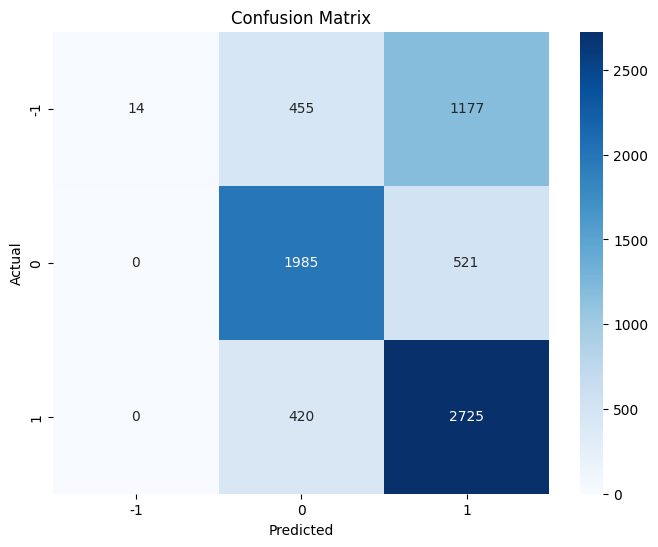

In [14]:
X_train, X_test, y_train, y_test = train_test_split(embedding, y, test_size=.2, random_state=0, stratify=y) # train-test split holdout validation

with mlflow.start_run() as run:
    # Experiments tags
    mlflow.set_tag("mlflow.runName", "RandomForest_baseline")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("Description", "Baseline model using a random forest classifier approach and a Bag of Words embedding technique")

    # parameters for vectorizer and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_maxfeatures", vectorizer.max_features)

    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 15)

    baseline_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=0)
    baseline_model.fit(X_train, y_train)
    predictions = baseline_model.predict(X_test)

    baseline_accuracy = accuracy_score(y_test, predictions)

    mlflow.log_metric("accuracy", baseline_accuracy)

    classification_rep = classification_report(y_test, predictions, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    class_names = [-1,0,1]

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    mlflow.sklearn.log_model(baseline_model, "random_forest_baseline")

print(f'Accuracy = {baseline_accuracy}')



In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1646
           0       0.69      0.79      0.74      2506
           1       0.62      0.87      0.72      3145

    accuracy                           0.65      7297
   macro avg       0.77      0.56      0.49      7297
weighted avg       0.73      0.65      0.57      7297

